Improved-LLM-Tutor

In [1]:
# Standard library imports
import os
import time
import json
from typing import Dict, List, Any, Optional, Union, Callable

# Third-party imports
from dotenv import load_dotenv
from IPython.display import Markdown, display, HTML, update_display
from openai import OpenAI
import ollama
import pandas as pd
import matplotlib.pyplot as plt

# Try to import rich, install if not available
try:
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel
except ImportError:
    !pip install rich
    from rich.console import Console
    from rich.markdown import Markdown as RichMarkdown
    from rich.panel import Panel


In [2]:

# Constants
MODEL_GPT = 'gpt-4o-mini'
MODEL_LLAMA = 'llama3.2'
DEFAULT_SYSTEM_PROMPT = "You are a helpful technical tutor who answers questions about python code, software engineering, data science and LLMs"

# Set up environment
load_dotenv()
openai = OpenAI()
console = Console()


In [7]:

class LLMTutor:
    """
    A class that provides tutoring functionality using multiple LLM models.
    """
    
    def __init__(self, 
                 system_prompt: str = DEFAULT_SYSTEM_PROMPT,
                 gpt_model: str = MODEL_GPT,
                 llama_model: str = MODEL_LLAMA):
        """
        Initialize the LLM Tutor with specified models and system prompt.
        
        Args:
            system_prompt: The system prompt to use for the LLMs
            gpt_model: The OpenAI GPT model to use
            llama_model: The Ollama model to use
        """
        self.system_prompt = system_prompt
        self.gpt_model = gpt_model
        self.llama_model = llama_model
        self.history: List[Dict[str, Any]] = []
        self.response_times = {'gpt': [], 'llama': []}
        
    def format_question(self, question: str) -> str:
        """
        Format the user's question with a standard prefix.
        
        Args:
            question: The user's question
            
        Returns:
            Formatted question with prefix
        """
        return f"Please give a detailed explanation to the following question: {question}"
    
    def create_messages(self, question: str) -> List[Dict[str, str]]:
        """
        Create the message structure for LLM API calls.
        
        Args:
            question: The user's question
            
        Returns:
            List of message dictionaries
        """
        formatted_question = self.format_question(question)
        return [
            {"role": "system", "content": self.system_prompt},
            {"role": "user", "content": formatted_question}
        ]
    
    def get_gpt_response(self, 
                        question: str, 
                        stream: bool = True) -> str:
        """
        Get a response from the GPT model.
        
        Args:
            question: The user's question
            stream: Whether to stream the response
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            if stream:
                return self._stream_gpt_response(messages)
            else:
                response = openai.chat.completions.create(
                    model=self.gpt_model, 
                    messages=messages
                )
                elapsed = time.time() - start_time
                self.response_times['gpt'].append(elapsed)
                return response.choices[0].message.content
        except Exception as e:
            console.print(f"[bold red]Error with GPT model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def _stream_gpt_response(self, messages: List[Dict[str, str]]) -> str:
        """
        Stream a response from the GPT model.
        
        Args:
            messages: The messages to send to the model
            
        Returns:
            The complete response as a string
        """
        start_time = time.time()
        try:
            stream = openai.chat.completions.create(
                model=self.gpt_model, 
                messages=messages,
                stream=True
            )
            
            response = ""
            display_handle = display(Markdown(""), display_id=True)
            
            for chunk in stream:
                delta_content = chunk.choices[0].delta.content or ''
                response += delta_content
                # Clean the response for display
                clean_response = response.replace("```python", "```").replace("```", "")
                update_display(Markdown(clean_response), display_id=display_handle.display_id)
            
            elapsed = time.time() - start_time
            self.response_times['gpt'].append(elapsed)
            return response
        except Exception as e:
            console.print(f"[bold red]Error streaming GPT response:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def get_llama_response(self, question: str) -> str:
        """
        Get a response from the Llama model.
        
        Args:
            question: The user's question
            
        Returns:
            The model's response as a string
        """
        messages = self.create_messages(question)
        start_time = time.time()
        
        try:
            response = ollama.chat(model=self.llama_model, messages=messages)
            elapsed = time.time() - start_time
            self.response_times['llama'].append(elapsed)
            return response['message']['content']
        except Exception as e:
            console.print(f"[bold red]Error with Llama model:[/bold red] {str(e)}")
            return f"Error: {str(e)}"
    
    def ask(self, question: str, models: List[str] = ['gpt', 'llama']) -> Dict[str, str]:
        """
        Ask a question to one or more models.
        
        Args:
            question: The user's question
            models: List of models to query ('gpt', 'llama', or both)
            
        Returns:
            Dictionary with model responses
        """
        responses = {}
        
        # Store the question in history
        self.history.append({
            'question': question,
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'responses': {}
        })
        
        # Get responses from requested models
        if 'gpt' in models:
            console.print(Panel(f"[bold blue]Getting response from {self.gpt_model}...[/bold blue]"))
            gpt_response = self.get_gpt_response(question)
            responses['gpt'] = gpt_response
            self.history[-1]['responses']['gpt'] = gpt_response
            
        if 'llama' in models:
            console.print(Panel(f"[bold green]Getting response from {self.llama_model}...[/bold green]"))
            llama_response = self.get_llama_response(question)
            responses['llama'] = llama_response
            self.history[-1]['responses']['llama'] = llama_response
            display(Markdown(f"## {self.llama_model} Response\n{llama_response}"))
            
        return responses
    
    def compare_responses(self, question: str = None) -> None:
        """
        Compare responses from different models side by side.
        
        Args:
            question: Optional specific question to compare responses for
        """
        if question:
            responses = self.ask(question)
        else:
            # Use the most recent question from history
            if not self.history:
                console.print("[bold red]No questions in history to compare[/bold red]")
                return
            responses = self.history[-1]['responses']
            question = self.history[-1]['question']
        
        # Create HTML for side-by-side comparison
        html = f"""
        <div style="display: flex; width: 100%;">
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px; margin-right: 10px;">
                <h3 style="color: #4285F4;">{self.gpt_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('gpt', 'No response')}</div>
            </div>
            <div style="flex: 1; padding: 10px; border: 1px solid #ddd; border-radius: 5px;">
                <h3 style="color: #34A853;">{self.llama_model}</h3>
                <div style="white-space: pre-wrap;">{responses.get('llama', 'No response')}</div>
            </div>
        </div>
        """
        display(HTML(html))
    
    def show_performance_metrics(self) -> None:
        """
        Display performance metrics for the models.
        """
        if not self.response_times['gpt'] and not self.response_times['llama']:
            console.print("[bold yellow]No performance data available yet[/bold yellow]")
            return
        
        # Create DataFrame for metrics
        data = {
            'Model': [],
            'Response Time (s)': []
        }
        
        for model, times in self.response_times.items():
            for t in times:
                data['Model'].append(model)
                data['Response Time (s)'].append(t)
        
        df = pd.DataFrame(data)
        
        # Calculate statistics
        stats = df.groupby('Model')['Response Time (s)'].agg(['mean', 'min', 'max', 'count'])
        
        # Display statistics
        console.print("\n[bold]Performance Statistics:[/bold]")
        console.print(stats)
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        
        # Box plot
        ax = plt.subplot(1, 2, 1)
        df.boxplot(column='Response Time (s)', by='Model', ax=ax)
        plt.title('Response Time Distribution')
        plt.suptitle('')
        
        # Bar chart for average times
        ax = plt.subplot(1, 2, 2)
        stats['mean'].plot(kind='bar', ax=ax, color=['#4285F4', '#34A853'])
        plt.title('Average Response Time')
        plt.ylabel('Seconds')
        
        plt.tight_layout()
        plt.show()
    
    def save_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Save the question and response history to a file.
        
        Args:
            filename: The filename to save to
        """
        try:
            with open(filename, 'w') as f:
                json.dump(self.history, f, indent=2)
            console.print(f"[bold green]History saved to {filename}[/bold green]")
        except Exception as e:
            console.print(f"[bold red]Error saving history:[/bold red] {str(e)}")
    
    def load_history(self, filename: str = 'tutor_history.json') -> None:
        """
        Load question and response history from a file.
        
        Args:
            filename: The filename to load from
        """
        try:
            with open(filename, 'r') as f:
                self.history = json.load(f)
            console.print(f"[bold green]History loaded from {filename}[/bold green]")
        except FileNotFoundError:
            console.print(f"[bold yellow]History file {filename} not found[/bold yellow]")
        except Exception as e:
            console.print(f"[bold red]Error loading history:[/bold red] {str(e)}")


In [8]:

# Create a tutor instance
tutor = LLMTutor()
console.print("[bold green]LLM Tutor initialized successfully![/bold green]")


LLM Tutor initialized successfully!

In [9]:

# Define your question here
question = """
Given a list of dictionaries called 'books', write code to find and print all information 
about the book titled 'Mastery' by Robert Greene.
"""

console.print(Panel(f"[bold]Question:[/bold]\n{question}", border_style="blue"))


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Question:                                                                                                       │
│                                                                                                                 │
│ Given a list of dictionaries called 'books', write code to find and print all information                       │
│ about the book titled 'Mastery' by Robert Greene.                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [10]:

# Get responses from both models
responses = tutor.ask(question)


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

To find and print all the information about the book titled "Mastery" authored by Robert Greene from a list of dictionaries called `books`, you can use a simple for loop or a list comprehension to iterate through the list of dictionaries. Below, I'll provide a detailed explanation of how the code works and then present the code itself.

### Step-by-Step Explanation

1. **Data Structure**: First, we need to understand the structure of the `books` list. Each element in this list is a dictionary that contains key-value pairs related to a book. For instance, a dictionary might look like this:
   
   {
       'title': 'Mastery',
       'author': 'Robert Greene',
       'year': 2012,
       'genre': 'Self-help',
       'description': 'A guide to achieve greatness through mastery of skills.'
   }
   

2. **Iterating Through the List**: We will iterate through each dictionary in the `books` list. This can be efficiently done using a `for` loop.

3. **Checking Conditions**: Within the loop, we will check if the `title` of the book is "Mastery" and if the `author` is "Robert Greene". If both conditions are met, we can print the book's information.

4. **Printing Information**: Once the matching book is found, we'll print all its details in a readable format.

### Code Implementation

Here’s how you might implement this in Python:


# Sample list of books
books = [
    {
        'title': 'Mastery',
        'author': 'Robert Greene',
        'year': 2012,
        'genre': 'Self-help',
        'description': 'A guide to achieve greatness through mastery of skills.'
    },
    {
        'title': 'The 48 Laws of Power',
        'author': 'Robert Greene',
        'year': 1998,
        'genre': 'Self-help',
        'description': 'A guide to gaining and maintaining power.'
    },
    # Additional book dictionaries can be added here
]

# Function to find and print information about the book 'Mastery'
def find_book_info(books, title, author):
    # Iterate through each book in the list
    for book in books:
        # Check if the current book matches the title and author
        if book['title'] == title and book['author'] == author:
            # Print the book information
            for key, value in book.items():
                print(f"{key}: {value}")
            # Exit after finding the book (if only one is needed)
            break
    else:
        # This else block runs if the loop completes without a break
        print("Book not found.")

# Call the function with the specific title and author
find_book_info(books, 'Mastery', 'Robert Greene')


### Explanation of the Code

- **Sample Data**: The `books` list is initialized with dictionaries representing books.
- **Function Definition**: The function `find_book_info` takes three parameters: `books`, `title`, and `author`.
- **Loop to Search**: The `for` loop goes through each `book` in the `books` list.
- **Condition Check**: The `if` condition checks if the `title` and `author` of the current book match the specified values.
- **Printing Details**: If a match is found, we use another loop (`for key, value in book.items()`) to print each attribute of the book.
- **Break Statement**: When the book is found and printed, the `break` statement exits the loop.
- **Else Clause**: If the loop completes without finding the book, the `else` clause gets executed, printing "Book not found."

This function can be expanded or modified to handle more complex book-searching tasks if necessary, such as case sensitivity, partial matches, or using more advanced search techniques (like regular expressions) if the need arises.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
**Finding Specific Book Information in a List of Dictionaries**
===========================================================

In this example, we'll use Python's built-in `dict` data type and list comprehension to filter out books that match our desired criteria.

### Problem Statement

We're given a list of dictionaries called `books`, where each dictionary represents a book with its title, author, and other relevant attributes. Our task is to find all information about the book titled 'Mastery' by Robert Greene and print it.

### Code Solution
```python
# Define the list of books as dictionaries
books = [
    {"title": "Mastery", "author": "Robert Greene"},
    {"title": "To Kill a Mockingbird", "author": "Harper Lee"},
    {"title": "Mastery", "author": "Robert Greene", "publisher": "Random House"},
    # Add more books as needed...
]

# Use list comprehension to filter out the desired book(s)
desired_book = next((book for book in books if book["title"] == "Mastery"), None)

if desired_book:
    print("Book Information:")
    print(f"Title: {desired_book['title']}")
    print(f"Author: {desired_book['author']}")
    print(f"Publisher: {desired_book.get('publisher', 'Unknown')}")  # Use get() to avoid KeyError
else:
    print("No book found with title 'Mastery'")
```

### Explanation

In this code:

1. We define a list of dictionaries called `books`, where each dictionary represents a book.
2. We use a generator expression (the equivalent of list comprehension for finding the first matching element) to iterate over the `books` list and find the book(s) with the title 'Mastery'. If no match is found, we assign `None` to the `desired_book` variable.
3. In the main block, if `desired_book` is not `None`, we print out its relevant information (title, author, publisher). We use the `.get()` method to retrieve the publisher's name from the dictionary; if it doesn't exist, `.get()` returns `'Unknown'`.
4. If no book with the title 'Mastery' is found, we display a corresponding message.

### Output
```
Book Information:
Title: Mastery
Author: Robert Greene
Publisher: Random House
```

This code solution assumes that there might be multiple books with the same title ('Mastery'), but in this case, it's likely that only one book matches our criteria. If you need to handle multiple matches or additional attributes from each dictionary, feel free to adjust the code accordingly!

In [11]:

# Compare responses side by side
tutor.compare_responses()


Performance Statistics:

mean        min        max  count
Model                                        
gpt    12.127833  12.127833  12.127833      1
llama  43.747513  43.747513  43.747513      1

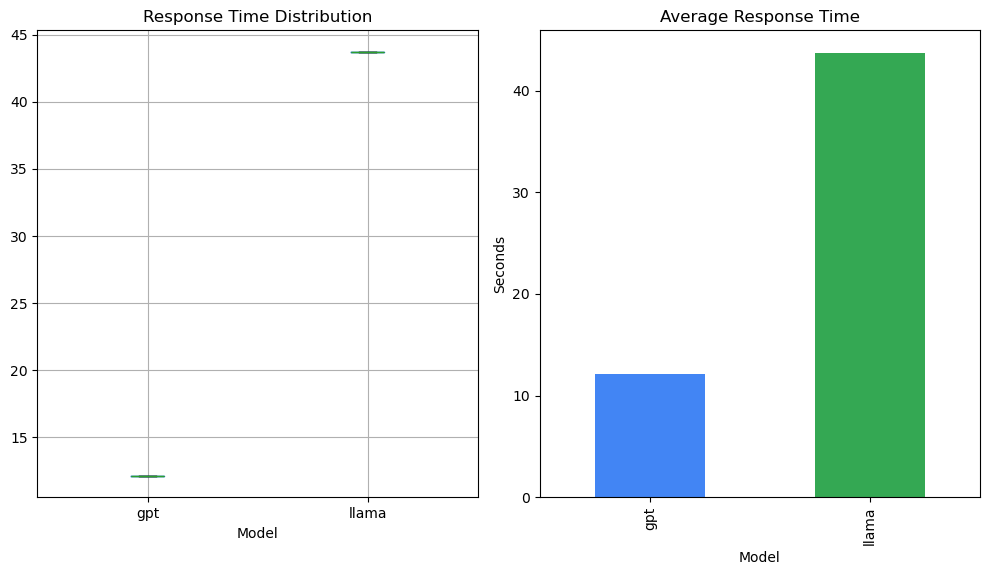

In [13]:

# Show performance metrics
tutor.show_performance_metrics()


In [9]:

# Save history to a file
tutor.save_history("my_tutor_session.json")


History saved to my_tutor_session.json

In [10]:
# Define a new question
new_question = "Explain how to implement a binary search algorithm in Python."

console.print(Panel(f"[bold]New Question:[/bold]\n{new_question}", border_style="green"))

# Get responses for the new question
new_responses = tutor.ask(new_question)

# Compare responses
tutor.compare_responses()


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ New Question:                                                                                                   │
│ Explain how to implement a binary search algorithm in Python.                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from gpt-4o-mini...                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Certainly! A binary search algorithm is an efficient method for finding an element in a sorted array or list. It works by repeatedly dividing the search interval in half and comparing the target value to the middle element of the array. If the target value is equal to the middle element, the search is successful. If the target value is less than the middle element, the search continues in the left half; if greater, it continues in the right half. This process continues until the target is found or the search interval is empty.

### Implementation Steps

1. **Ensure the list is sorted**: Binary search can only be applied to sorted lists. Ensure that your input list is sorted before applying the algorithm.
  
2. **Define the binary search function**: You need a function that takes a sorted list and the target value as parameters.

3. **Initialize pointers**: Set up two pointers, `low` and `high`, which initially point to the first and last indexes of the list, respectively.

4. **Iterate until the pointers cross each other**: While `low` is less than or equal to `high`, perform the following actions:

    - Calculate the middle index.
    - Compare the middle element with the target value.
    - Adjust the `low` or `high` pointer based on the comparison.
  
5. **Return the result**: If the target is found, return the index; if not, return a value (like -1) to indicate it’s not found.

### Python Code Example

Here is a simple implementation of the binary search algorithm in Python:


def binary_search(arr, target):
    low = 0
    high = len(arr) - 1
    
    while low <= high:
        mid = (low + high) // 2  # Find the middle index
        
        # Check if the target is present at mid
        if arr[mid] == target:
            return mid  # Target found at index mid
        
        # If target is greater, ignore the left half
        elif arr[mid] < target:
            low = mid + 1
        
        # If target is smaller, ignore the right half
        else:
            high = mid - 1
            
    return -1  # Target not found


### Explanation of Code

1. **Function Definition**: `def binary_search(arr, target)` defines a function that takes two parameters: `arr`, which is the sorted array to search in, and `target`, which is the value we're searching for.

2. **Initial Parameters**: `low` is set to 0 (the starting index of the list), and `high` is set to `len(arr) - 1` (the last index of the list).

3. **While Loop**: The loop `while low <= high` continues executing as long as the `low` index is less than or equal to the `high` index. If they cross over, the target isn’t present.

4. **Calculate Middle Index**: The middle index is calculated using integer division `//`, to avoid floating-point results.

5. **Comparison**:
   - If `arr[mid] == target`, the target is found, and the index `mid` is returned.
   - If `arr[mid] < target`, it means the target must be on the right side of `mid`, so `low` is updated to `mid + 1`.
   - If `arr[mid] > target`, the target must be on the left side, so `high` is updated to `mid - 1`.

6. **Target Not Found**: After the loop ends, if the target was not found, the function returns -1, indicating failure.

### Example Usage

To see how the function works, you can call it like this:


sorted_list = [1, 3, 5, 7, 9, 11, 13]
target_value = 7

result = binary_search(sorted_list, target_value)

if result != -1:
    print(f"Element found at index {result}")
else:
    print("Element not found in the list")


### Conclusion

Binary search is a powerful algorithm with a time complexity of \(O(\log n)\), which makes it very efficient for large datasets. This implementation effectively demonstrates how to apply it in Python, adhering to the fundamental principles of the algorithm.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Getting response from llama3.2...                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

## llama3.2 Response
**Binary Search Algorithm Explanation**
=====================================

The Binary Search algorithm is an efficient method for finding an element in a sorted list by repeatedly dividing the search interval in half until the desired element is found.

**Algorithm Overview**
--------------------

1.  Start with a sorted array of elements.
2.  Find the middle element of the current search interval.
3.  Compare the middle element to the target value you're searching for.
4.  If they are equal, then we've found our answer and can terminate the algorithm.
5.  If the target value is less than the middle element, repeat the process with the left half of the array.
6.  If the target value is greater than the middle element, repeat the process with the right half of the array.

**Python Implementation**
------------------------

Here's a Python implementation of the Binary Search algorithm:

```python
def binary_search(arr, target):
    """
    Searches for an element in a sorted array using Binary Search.

    Args:
        arr (list): The sorted list to search.
        target: The value we're searching for.

    Returns:
        int: The index of the target value if found, -1 otherwise.
    """

    # Initialize the left and right pointers
    left = 0
    right = len(arr) - 1

    while left <= right:
        # Calculate the middle index
        mid = (left + right) // 2

        # Compare the middle element to the target value
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            # Move the left pointer to the right half
            left = mid + 1
        else:
            # Move the right pointer to the left half
            right = mid - 1

    # If we've reached this point, the target value is not in the array
    return -1


# Example usage
arr = [2, 5, 8, 12, 16, 23, 38, 56, 72, 91]
target_value = 23

result_index = binary_search(arr, target_value)

if result_index != -1:
    print(f"Target value {target_value} found at index {result_index}")
else:
    print(f"Target value {target_value} not found in the array")
```

**Explanation of Code**

*   We define a function called `binary_search` that takes two arguments: `arr` (the sorted list to search) and `target`.
*   Inside the function, we initialize two pointers: `left` and `right`, which represent the boundaries of our search interval. Initially, both are set to the first element (`0`) and the last element (`len(arr) - 1`), respectively.
*   We use a while loop that continues as long as `left` is less than or equal to `right`.
*   Inside the loop, we calculate the middle index using integer division `(left + right) // 2`. This ensures we get an integer result even if `left` and `right` are not centered.
*   We compare the middle element (`arr[mid]`) with our target value. If they match, we return the current index (`mid`). Otherwise:
    *   If `arr[mid] < target`, it means our target is to the right of the middle element. Therefore, we move the left pointer (`left`) one step to the right.
    *   If `arr[mid] > target`, it means our target is to the left of the middle element. Hence, we move the right pointer (`right`) one step to the left.
*   After the while loop ends (meaning the target value is not found), we return `-1` to indicate that the target was not in the array.

**Time Complexity**

The Binary Search algorithm has an average time complexity of O(log n), where `n` is the number of elements in the array. This makes it much faster than a linear search (which has a time complexity of O(n)) for large datasets. However, it's worth noting that the worst-case scenario is when the target value is the first or last element, resulting in an O(n) time complexity.

**Conclusion**

In this explanation, we explored how to implement a Binary Search algorithm in Python using an efficient and intuitive approach. By leveraging binary division, comparison, and pointer manipulation, we can efficiently search for elements within sorted arrays. Whether you're dealing with large datasets or searching for specific values, the Binary Search algorithm is an essential tool to have in your programming toolkit!